# Saturation test 

In [23]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import matplotlib.ticker as ticker
import matplotlib as mpl
import sys
from math import *
from scipy.stats import binned_statistic
import inspect
import matplotlib as mpl
import ast
from statistics import mean
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr



sns.set_context("talk")

# Import custom functions
from utils_benchmark import * 
#test()

sns.set_style("white")

evaluation_dir = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/"
outdir = "../../../data/structural_regression/plots/02_benchmarkCPU/"
stats_dir = "/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/"

summary_homfam_exthomfam = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/01_summary_homfam_exthomfam.csv")
summary_homfam_exthomfam = summary_homfam_exthomfam.rename(columns={"dataset": "benchmarking_dataset"})
# AF2
af2 = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/02_summary_af2.csv")
af2_grouped = pd.read_csv("/home/luisasantus/Desktop/crg_cluster/data/structural_regression/stats/03_summary_af2_grouped.csv")
metrics = [["sp", "sum of pairs"], ["tc", "total column"], ["column", "column"]]


scores_df = pd.read_csv(os.path.join(stats_dir, "03_scores_df.csv"))

### SUBSELECT

In [63]:
fams_saturation = ["cryst","egf","cyt"]
fams = ["cryst","egf","cyt3"]

In [65]:
dataset = "homfam"
scores_dir = join("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/",dataset,"evaluation/score/")

scores = pd.DataFrame()
for score_name in os.listdir(scores_dir):
    score_file = os.path.join(scores_dir,score_name)
    if score_name.startswith(tuple(fams)):
    # only retain the ones in the subset 
        if score_file.endswith(".scores"):
            score_df = pd.read_csv(score_file,sep = ";", header = None).drop(4, axis = 1)
            scores = pd.concat([scores,score_df], ignore_index=True)
scores = scores.drop([5,6,7], axis = 1)

In [66]:
# Extract from .score files 
dataset = "homfam"
alignments_dir = join("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/",dataset,"alignments/")
buckets_summary = pd.DataFrame()
for root, dirs, files in os.walk(alignments_dir):
    for name in files:
        # Only retain subset 
        file = os.path.join(root,name)
        if file.endswith("bucket.log"):
            name = os.path.basename(os.path.dirname(file))
            if name.startswith("hormone"):
                print(name)
            buckets = list(pd.read_csv(file, header = None, engine='python', delim_whitespace=True)[3])
            less_50 = sum(i <= 50 for i in buckets)
            more_50 = sum(i > 50 for i in buckets)
            less_100 = sum(i <= 100 for i in buckets)
            more_100 = sum(i > 100 for i in buckets)
            mean_buckets = mean(buckets)
            tot = less_50 + more_50
            buckets_df = pd.DataFrame(data = {"name" : [name], "buckets" : [buckets], 
                                             "less_50":less_50, "more_50":more_50, 
                                             "less_100": less_100, "more_100": more_100, "mean_buckets": mean_buckets, 
                                              "tot": tot})
            buckets_df = buckets_df.astype("object")
            buckets_summary = pd.concat([buckets_summary,buckets_df], ignore_index=True)

hormone_rec.regressive.50.FAMSA.FAMSA-medoid
hormone_rec.regressive.50.FAMSA.MBED


In [67]:
import warnings
warnings.filterwarnings("ignore")
scores.columns = ['name', 'sp', 'tc', 'column']
# -------------------------
#      Regressive
# -------------------------
regressive_scores = scores[scores.name.str.contains("regressive")]
regressive_scores[["family", "method", "bucket_size", "align_method", "tree_method"]] = regressive_scores.name.str.split(".", expand = True)
regressive_scores["benchmarking_dataset"] = "homfam"

# -------------------------
#      Progressive
# -------------------------
progressive_scores = scores[scores.name.str.contains("progressive")]
progressive_scores[["family", "method", "align_method", "tree_method"]] = progressive_scores.name.str.split(".", expand = True)
progressive_scores["benchmarking_dataset"] = "homfam"

# -------------------------
#      Dyanmic
# -------------------------
dynamic_scores = scores[scores.name.str.contains("dynamic")]
dynamic_scores[["family", "method", "bucket_size", "dynamicX_label","dynamicX_val","master_msa", "slave_msa", "tree_method"]] = dynamic_scores.name.str.split(".", expand = True)

In [82]:
# In this analysis I am not interested in the effect of DynamicX.
# I therefore fix it at 100000000.
dynamic_scores = dynamic_scores[dynamic_scores.dynamicX_val == "100000000" ]

# I will also now not use the reference values 
# To keep it simple at the beginning
dynamic_scores = dynamic_scores[dynamic_scores.family.str.contains("ref") == False]
dynamic_scores = dynamic_scores[dynamic_scores.master_msa == "tcoffee_msa"]
dynamic_scores = dynamic_scores[dynamic_scores.slave_msa == "famsa_msa"]

dynamic_scores["benchmarking_dataset"] = "homfam"

# Prep dataset 
stats_dynamic = pd.merge(dynamic_scores, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])

# add buckets
stats_dynamic = pd.merge(stats_dynamic,buckets_summary, how = "left", on = "name")

# Retain the families for which i have all the calculations
stats_dynamic.head(1)


scores_df = pd.concat([regressive_scores, progressive_scores, dynamic_scores], ignore_index=True, sort=False)
scores_df = pd.merge(scores_df, summary_homfam_exthomfam, on =["family","benchmarking_dataset"])
scores_df = pd.merge(scores_df,buckets_summary, how = "outer", on = "name")
scores_df = scores_df[scores_df.family.str.contains("ref") == False]

scores_df = scores_df[scores_df.tree_method =="FAMSA-medoid"]

# dataset for ploting

In [83]:
df = scores_df
df_dyn = df[(df.method == "dynamic") & (df.dynamicX_val == "100000000") & (df.master_msa == "tcoffee_msa")]
df_dyn = df_dyn[df_dyn.family.isin(fams)]


In [84]:

df_prog = df[(df.method == "progressive") & (df.family.isin(fams))]
df_reg = df[(df.method == "regressive")  & (df.bucket_size == 50) & (df.family.isin(fams))]
df = pd.concat([df_dyn, df_reg, df_prog])

df["method_expanded"] = df[["method", "bucket_size"]].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
df.method_expanded = df.method_expanded.str.replace("_nan", "")

In [85]:
df

,name,sp,tc,column,family,method,bucket_size,align_method,tree_method,benchmarking_dataset,...,size_group,perc_ref_total,buckets,less_50,more_50,less_100,more_100,mean_buckets,tot,method_expanded
7,egf.dynamic.100.dynamicX.100000000.tcoffee_msa...,60.0,13.2,22.5,egf,dynamic,100,NaN,FAMSA-medoid,homfam,...,medium,0.154361,"[100, 51, 1654, 427, 3075, 3, 30, 45, 799, 15,...",41,16,49,8,137.368421,57,dynamic_100
8,egf.dynamic.50.dynamicX.100000000.tcoffee_msa....,63.8,16.2,28.0,egf,dynamic,50,NaN,FAMSA-medoid,homfam,...,medium,0.154361,"[50, 16, 1705, 3535, 896, 64, 2, 97, 74, 53, 3...",20,13,26,7,236.545455,33,dynamic_50
9,egf.dynamic.150.dynamicX.100000000.tcoffee_msa...,59.9,19.1,32.7,egf,dynamic,150,NaN,FAMSA-medoid,homfam,...,medium,0.154361,"[150, 127, 1527, 27, 3048, 29, 44, 104, 695, 4...",62,16,67,11,100.653846,78,dynamic_150
15,cryst.dynamic.150.dynamicX.100000000.tcoffee_m...,43.6,0.0,0.0,cryst,dynamic,150,NaN,FAMSA-medoid,homfam,...,small,0.603448,"[150, 22, 3, 6, 25, 5, 25, 33, 3, 102, 4, 10, ...",61,6,64,3,18.298507,67,dynamic_150
16,cryst.dynamic.100.dynamicX.100000000.tcoffee_m...,68.4,1.1,0.7,cryst,dynamic,100,NaN,FAMSA-medoid,homfam,...,small,0.603448,"[100, 23, 4, 5, 31, 6, 105, 2, 58, 71, 48, 7, ...",48,7,53,2,22.072727,55,dynamic_100
17,cryst.dynamic.50.dynamicX.100000000.tcoffee_ms...,47.8,0.6,0.3,cryst,dynamic,50,NaN,FAMSA-medoid,homfam,...,small,0.603448,"[50, 72, 119, 2, 16, 10, 28, 41, 13, 65, 4, 82...",28,8,32,4,33.194444,36,dynamic_50
23,cyt3.dynamic.150.dynamicX.100000000.tcoffee_ms...,67.4,29.7,34.1,cyt3,dynamic,150,NaN,FAMSA-medoid,homfam,...,small,1.558442,"[150, 3, 6, 26, 5, 5, 8, 2, 3, 5, 18, 3, 20, 7...",47,1,47,1,9,48,dynamic_150
24,cyt3.dynamic.100.dynamicX.100000000.tcoffee_ms...,60.3,14.4,14.6,cyt3,dynamic,100,NaN,FAMSA-medoid,homfam,...,small,1.558442,"[100, 4, 6, 32, 3, 13, 3, 4, 23, 5, 23, 2, 8, ...",43,1,44,0,9.727273,44,dynamic_100
25,cyt3.dynamic.50.dynamicX.100000000.tcoffee_msa...,58.2,9.3,9.3,cyt3,dynamic,50,NaN,FAMSA-medoid,homfam,...,small,1.558442,"[50, 6, 42, 32, 5, 18, 2, 4, 14, 31, 3, 11, 11...",32,0,32,0,13,32,dynamic_50
6,egf.progressive.FAMSA.FAMSA-medoid,66.3,16.2,28.0,egf,progressive,NaN,FAMSA,FAMSA-medoid,homfam,...,medium,0.154361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,progressive


In [90]:
df[df.family =="cryst"]

,name,sp,tc,column,family,method,bucket_size,align_method,tree_method,benchmarking_dataset,...,size_group,perc_ref_total,buckets,less_50,more_50,less_100,more_100,mean_buckets,tot,method_expanded
15,cryst.dynamic.150.dynamicX.100000000.tcoffee_m...,43.6,0.0,0.0,cryst,dynamic,150,NaN,FAMSA-medoid,homfam,...,small,0.603448,"[150, 22, 3, 6, 25, 5, 25, 33, 3, 102, 4, 10, ...",61,6,64,3,18.298507,67,dynamic_150
16,cryst.dynamic.100.dynamicX.100000000.tcoffee_m...,68.4,1.1,0.7,cryst,dynamic,100,NaN,FAMSA-medoid,homfam,...,small,0.603448,"[100, 23, 4, 5, 31, 6, 105, 2, 58, 71, 48, 7, ...",48,7,53,2,22.072727,55,dynamic_100
17,cryst.dynamic.50.dynamicX.100000000.tcoffee_ms...,47.8,0.6,0.3,cryst,dynamic,50,NaN,FAMSA-medoid,homfam,...,small,0.603448,"[50, 72, 119, 2, 16, 10, 28, 41, 13, 65, 4, 82...",28,8,32,4,33.194444,36,dynamic_50
14,cryst.progressive.FAMSA.FAMSA-medoid,48.2,2.2,0.9,cryst,progressive,NaN,FAMSA,FAMSA-medoid,homfam,...,small,0.603448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,progressive


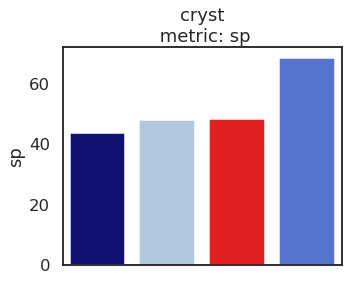

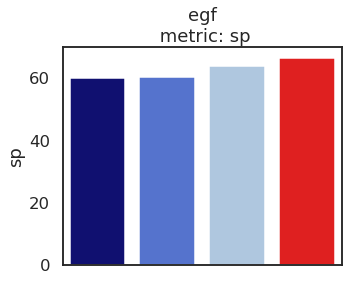

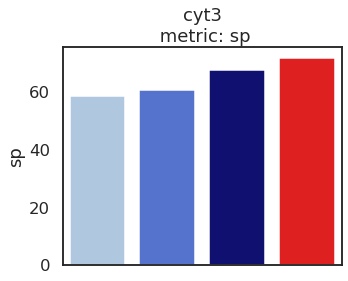

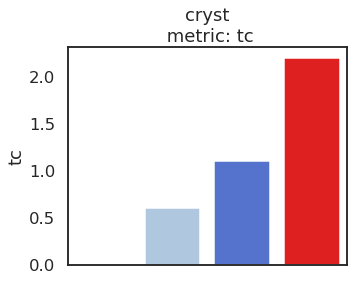

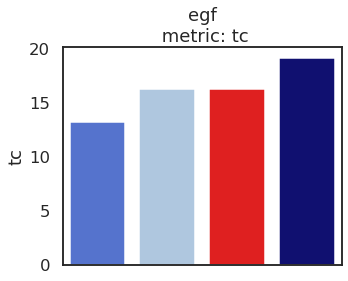

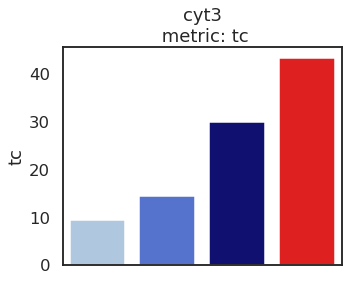

In [110]:
for metric in ["sp", "tc"]:
    for family in fams: 
        df_plot = df[df.family == family]
        f, ax = plt.subplots(figsize=(5, 4))
        ax=sns.barplot(x="name", y=metric, data=df_plot, dodge = False,  \
                       hue="method_expanded", order=df_plot.sort_values(metric).name, \
                       palette =dict(progressive="red", dynamic_50="#A7C7E7", dynamic_100="#4169E1", dynamic_150 = "#000080"))
        ax.set(xticklabels="", xlabel = "", ylabel = metric,\
               title = family + "\n metric: "+metric)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        ax.legend_.remove()


In [ ]:
\
                   palette =dict(progressive="grey", dynamic_50="#A7C7E7", dynamic_100="#4169E1", dynamic_150 = "#000080")